In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style
from torch.utils.data import DataLoader , TensorDataset, SubsetRandomSampler

In [2]:
MODEL_NAME = f"model-{time.asctime()}" 

In [65]:
BATCH_SIZE = 75
EPOCHS = 30
PT = "model/model2.pt" #path to existing model
IMG_SIZE = 50
VAL_PCT = 0.1
LR = 0.001
path = "D:/projects/Neural_Networks/coursera_v2/PetImages/test/cat/183.jpeg" #path to single image
PATH = "training_data.npy" #path to training data


In [4]:
REBUILD_DATA =False # set to true to one once, then back to false unless you want to change something in your

In [5]:

# preparing data.
class DogsVSCats():
    #IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" or "jpeg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[
                            self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot
                        # print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        # print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save(PATH, self.training_data)
        print('Cats:', dogsvcats.catcount)
        print('Dogs:', dogsvcats.dogcount)


In [6]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [8]:
#neural network with dropout

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
#        self.bn1 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(32, 64, 5)
#        self.bn2 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.bn1 = nn.BatchNorm1d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.AlphaDropout(p=0.3)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

        '''>>> # With Learnable Parameters
        >>> m = nn.BatchNorm2d(100)
        >>> # Without Learnable Parameters
        >>> m = nn.BatchNorm2d(100, affine=False)
        >>> input = torch.randn(20, 100, 35, 45)
        >>> output = m(input)'''

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        x = self.dropout(x)
        return F.softmax(x, dim=1)

In [9]:
#creating model & parameters
net = Net().to(device)

#parameters
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()

In [14]:
#define a data loader function

def load_data(path):
    data = np.load(path, allow_pickle=True)
    print(len(data))   
    X = torch.Tensor([i[0] for i in data]).view(-1, 50, 50) #images
    X = X / 255.0 # scaling the data
    print(X.size())
    y = torch.Tensor([i[1] for i in data]) #observations / real labels
    
    return X, y

In [16]:
PATH = "testing_data.npy"

X, y = load_data(PATH)

24998
torch.Size([24998, 50, 50])


In [17]:
def create_sets(X,y):
    val_size = int(len(X) * VAL_PCT)
    print(val_size)

    #creating data and train sets.

    train_X = X[:-val_size]
    train_y = y[:-val_size]

    test_X = X[-val_size:]
    test_y = y[-val_size:]

    print(len(train_X))
    print(len(test_X))

    print(len(X)/2499)
    sampler = SubsetRandomSampler(list(range(int(len(train_X)))))

    test_sampler = SubsetRandomSampler(list(range(int(len(test_X)))))

    t_dataset = TensorDataset(train_X , train_y)
    trainloader = DataLoader(t_dataset , batch_size = BATCH_SIZE, sampler= sampler)

    v_dataset = TensorDataset(test_X, test_y)
    testloader = DataLoader(v_dataset, batch_size = BATCH_SIZE, sampler= test_sampler)
    
    return trainloader, testloader, val_size

train, test, validsize= create_sets(X,y)

n = len(X) - validsize # iteration number
print(n)

2499
22499
2499
10.003201280512204
22499


In [18]:
def Train(net):
    with open("model_new.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, n, BATCH_SIZE)):   
                dt = next(iter(train))
                batch_X = dt[0].view(-1, 1, 50, 50)
                batch_y = dt[1]
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y , train_=True)
                
                if i % 50 == 0:
                    val_acc, val_loss = Test(size=100)
                    f.write(
                        f"{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},"
                        f"{round(float(val_acc), 2)},{round(float(val_loss), 4)},{epoch}\n")
                    torch.save({
                        'dropout cnn model': MODEL_NAME,
                        'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()
                    }, PT)


In [19]:
def Test(size=32):
    test_dt = next(iter(test))
    X, y = test_dt[0].view(-1, 1, 50, 50), test_dt[1]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

In [20]:
def create_acc_loss_graph(model_name):
    contents = open("model_new.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

In [55]:
def fwd_pass(X, y, net, train_=False):
    if train_:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs, y)

    if train_:
        loss.backward()
        optimizer.step()

    return acc, loss

In [22]:
style.use("ggplot")
MODEL_NAME = f"model-{time.asctime()}" 
print(MODEL_NAME)

model-Mon Jul 20 21:04:13 2020


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:47<00:00,  6.28it/s]


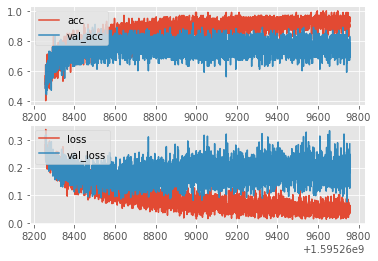

In [23]:
Train(net)
create_acc_loss_graph(MODEL_NAME)

In [24]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 5, 5])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 5, 5])
conv3.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
bn1.weight 	 torch.Size([512])
bn1.bias 	 torch.Size([512])
bn1.running_mean 	 torch.Size([512])
bn1.running_var 	 torch.Size([512])
bn1.num_batches_tracked 	 torch.Size([])
fc2.weight 	 torch.Size([2, 512])
fc2.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {1822099262704: {'step': 9000, 'exp_avg': tensor([[[[ 3.5754e-04,  1.5102e-04,  2.6843e-04,  1.3288e-03,  7.4696e-04],
          [ 4.5562e-04,  8.7622e-04, -5.9135e-04,  1.0075e-03,  8.3646e-04],
          [ 3.3273e-04, -1.9231e-04,  1.5815e-04,  4.3616e-04,  1.1167e-03],
          [-6.3052e-04, -2.4334e-04,  3.7482e-04,  1.2892e-03,  3.6216e-04],
          [-5.4123e-04, -9.4093e-04,  2.7893e-05, -9.4251e-05,  1.3342e-04]]],




In [26]:
# loading existing model:

model = Net().to(device)
opt = optim.Adam(net.parameters(), lr=0.001)

checkpoint = torch.load(PT)
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])

print("Optimizer's state_dict:")
for var_name in opt.state_dict():
    print(var_name, "\t", opt.state_dict()[var_name])

Optimizer's state_dict:
state 	 {1822099262704: {'step': 8999, 'exp_avg': tensor([[[[-4.9136e-04, -3.7111e-04, -2.1869e-04,  2.6805e-04,  4.4595e-04],
          [-3.4209e-04, -5.6289e-04, -3.9021e-04,  1.6120e-04,  3.2572e-04],
          [-8.3524e-04, -3.2768e-04,  1.3113e-04,  4.2596e-04,  7.3641e-05],
          [-9.6669e-04, -7.7848e-04,  2.0878e-04,  4.3242e-04, -3.3311e-04],
          [-1.1446e-03, -1.6948e-03, -5.8632e-04, -4.8552e-04, -2.5982e-04]]],


        [[[ 2.1521e-03,  4.2957e-03,  1.0433e-02,  5.4761e-03,  6.6182e-03],
          [-1.2323e-03,  1.4983e-04, -4.4691e-05,  2.1097e-03, -1.4017e-03],
          [-2.6313e-03,  1.5720e-03, -1.4358e-03,  3.3027e-04, -2.9838e-03],
          [ 1.1290e-03,  6.7449e-04,  6.6997e-04, -1.1153e-03, -2.8749e-03],
          [ 1.2730e-03,  2.4967e-03,  3.6056e-03,  2.8189e-04,  1.3698e-03]]],


        [[[ 2.8416e-04,  5.7008e-04,  1.5940e-04,  2.2194e-04,  1.6439e-03],
          [-1.8462e-03, -1.3472e-03, -1.8799e-03, -1.8556e-03,  2.2456e

True
tensor([[1.0000e+00, 2.8844e-15]], device='cuda:0', grad_fn=<SoftmaxBackward>)
1.0 tensor(4.1600e-30, device='cuda:0', grad_fn=<MseLossBackward>)
Machine has predicted True! It predicted tensor([[1.0000e+00, 2.8844e-15]], device='cuda:0', grad_fn=<SoftmaxBackward>) and the input was a image of tensor([1., 0.], device='cuda:0'). 


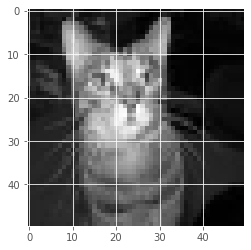

In [67]:
def single_image_prediction(path):
    print(os.path.exists(path))

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE )

    #if img == None: # older numpy / py2
        # fail !!
    #    print("fail!1")

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img, cmap='gray')

    x = torch.Tensor([i for i in img]).view(-1, 1, 50, 50)
    x = x/255
    x = x.to(device)

    y= torch.Tensor([1,0]).to(device)

    model.eval()
    yhat = model(x)
    print(yhat)
    
    #net.eval()
    acc_, loss_ = fwd_pass(x, y, model)
    print(acc_, loss_)
    
    if acc_ == 1.0:
        print(f"Machine has predicted True! It predicted {yhat} and the input was a image of {y}. ")
    else: 
        print(f"Machine has predicted False! It predicted {yhat} and the input was a image of {y}. ")
    
    return

single_image_prediction(path)

In [46]:
"""yhat = []
for i in range(500):
    fname = "D:/projects/Neural_Networks/coursera_v2/PetImages/dog/" + str(i)+ ".jpeg"
    #print(fname)
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    
    #if img == None: # older numpy / py2
    # fail !!
    #    print("fail!1")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img, cmap='gray')

    test_x = x.view(-1, 1, 50, 50)
    test_x = test_x.to(device)
    net.eval()
    #with torch.no_grad():
    yhat.append(net(test_x))
    print(yhat[i])
    
matches = [torch.argmax(yhat[i]) == torch.argmax(y) for i in range(len(yhat))]
acc = matches.count(True) / len(matches)
print(acc)"""

In [ ]:
"""sample = test_X[0:0 + BATCH_SIZE].view(-1, 1, 50, 50)
sample = sample.to(device)
#with torch.no_grad():
output = model(sample)
acc_, loss_ = fwd_pass(sample,test_y[0:0 + BATCH_SIZE].to(device) )
print(acc_, loss_)
print(output, "=?", test_y[0:0 + BATCH_SIZE]) """

In [39]:
samples = np.load("testing_data.npy", allow_pickle=True)
print(len(samples))

1


In [57]:
x = torch.Tensor([i[0] for i in samples]).view(-1, 1, 50, 50)
x = x / 255.0 # scaling the data

print(x)
obs = torch.Tensor([i[1] for i in samples])

tensor([[[[0.0824, 0.0980, 0.0824,  ..., 0.0627, 0.0784, 0.0549],
          [0.0784, 0.0902, 0.0863,  ..., 0.0392, 0.0667, 0.0549],
          [0.1020, 0.0980, 0.1137,  ..., 0.0471, 0.0627, 0.0275],
          ...,
          [0.1451, 0.1490, 0.1529,  ..., 0.0078, 0.0118, 0.0118],
          [0.1451, 0.1490, 0.1529,  ..., 0.0118, 0.0157, 0.0118],
          [0.1373, 0.1490, 0.1490,  ..., 0.0039, 0.0078, 0.0118]]]])


In [58]:
model = Net().to(device)
opt = optim.Adam(net.parameters(), lr=0.001)

checkpoint = torch.load(PT)
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()
outputs = model(x.to(device))

In [59]:
print(outputs)

tensor([[1.0000e+00, 2.8844e-15]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [62]:
#net.eval()
acc_, loss_ = fwd_pass(x.to(device), obs.to(device), model)

In [63]:
print(acc_, loss_)

1.0 tensor(4.1600e-30, device='cuda:0', grad_fn=<MseLossBackward>)


In [64]:
fname = "D:/projects/Neural_Networks/coursera_v2/PetImages/test/cat/183.jpeg"
    #print(fname)
img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    
    #if img == None: # older numpy / py2
    # fail !!
    #    print("fail!1")
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
x_ = torch.Tensor([i for i in img]).view(-1, 1, 50, 50)
x_ = x_ / 255.0
print(x_)

outout= model(x_.to(device))

print(outout)

tensor([[[[0.0824, 0.0980, 0.0824,  ..., 0.0627, 0.0784, 0.0549],
          [0.0784, 0.0902, 0.0863,  ..., 0.0392, 0.0667, 0.0549],
          [0.1020, 0.0980, 0.1137,  ..., 0.0471, 0.0627, 0.0275],
          ...,
          [0.1451, 0.1490, 0.1529,  ..., 0.0078, 0.0118, 0.0118],
          [0.1451, 0.1490, 0.1529,  ..., 0.0118, 0.0157, 0.0118],
          [0.1373, 0.1490, 0.1490,  ..., 0.0039, 0.0078, 0.0118]]]])
tensor([[1.0000e+00, 2.8844e-15]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [ ]:
len(train_X)

In [ ]:
len(X)

In [ ]:
val_size

In [ ]:
len(X)- val_size

In [ ]:
print(f"Machine has predicted True! It is a {outout}")